## ResNet 50

In [1]:
###### check gpu
import tensorflow as tf
from tensorflow.python.client import device_lib
import pandas as pd
import numpy as np
import glob
import random
import locale
from PIL import Image
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
#import tensorflow_addons as tfa
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.layers import concatenate, Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
from tensorflow.keras.utils import plot_model

from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Activation,Dropout,Dense
from tensorflow.keras.optimizers import Adam

import string
from keras.preprocessing import image as krs_image

# feature selection libraries
from sklearn.feature_selection import RFE

In [2]:
color_gt = ['RGB-R', 'RGB-G','RGB-B','HSL-H','HSL-S','HSL-L']
object_gt = ['aeroplane','apple','backpack','banana','baseball bat','baseball glove','bear','bed','bench','bicycle',
'bird','boat','book','bottle','bowl','broccoli','bus','cake','car','carrot','cat','cell phone','chair',
'clock','cow','cup','diningtable','dog','donut','elephant','fire hydrant','fork','frisbee','giraffe',
'handbag','horse','hot dog','keyboard','kite','knife','laptop','microwave','motorbike','mouse','orange',
'oven','parking meter','person','pizza','pottedplant','refrigerator','remote','sandwich','scissors','sheep',
'sink','skateboard','skis','snowboard','sofa','spoon','sports ball','stop sign','suitcase','surfboard',
'teddy bear','tennis racket','tie','toilet','toothbrush','traffic light','train','truck','tvmonitor','umbrella',
'vase','wine glass','zebra']
scene_gt = ['Indoor/Outdoor','shopping and dining','workplace (office building, factory, lab, etc.)',
'home or hotel','transportation (vehicle interiors, stations, etc.)','sports and leisure','cultural (art, education, religion, millitary, law, politics, etc.)',
'water, ice, snow','mountains, hills, desert, sky','forest, field, jungle','man-made elements','transportation (roads, parking, bridges, boats, airports, etc.)',
'cultural or historical building/place (millitary, religious)','sports fields, parks, leisure spaces','industrial and construction','houses, cabins, gardens, and farms',
'commercial buildings, shops, markets, cities, and towns','airfield','airplane_cabin','airport_terminal','alcove','alley','amphitheater','amusement_arcade',
'amusement_park','apartment_building/outdoor','aquarium','aqueduct','arcade','arch','archaelogical_excavation','archive','arena/hockey','arena/performance',
'arena/rodeo','army_base','art_gallery','art_school','art_studio','artists_loft','assembly_line','athletic_field/outdoor','atrium/public','attic','auditorium',
'auto_factory','auto_showroom','badlands','bakery/shop','balcony/exterior','balcony/interior','ball_pit','ballroom','bamboo_forest','bank_vault','banquet_hall',
'bar','barn','barndoor','baseball_field','basement','basketball_court/indoor','bathroom','bazaar/indoor','bazaar/outdoor','beach','beach_house','beauty_salon',
'bedchamber','bedroom','beer_garden','beer_hall','berth','biology_laboratory','boardwalk','boat_deck','boathouse','bookstore','booth/indoor','botanical_garden',
'bow_window/indoor','bowling_alley','boxing_ring','bridge','bullring','burial_chamber','bus_interior','bus_station/indoor','butchers_shop','butte','cabin/outdoor',
'campsite','campus','canal/natural','canal/urban','candy_store','canyon','car_interior','carrousel','castle','catacomb','cemetery','chalet','chemistry_lab',
'childs_room','church/indoor','church/outdoor','classroom','clean_room','cliff','closet','clothing_store','coast','cockpit','coffee_shop','computer_room',
'conference_center','conference_room','construction_site','corn_field','corral','corridor','cottage','courthouse','courtyard','creek','crevasse','crosswalk',
'dam','delicatessen','department_store','desert/sand','desert/vegetation','desert_road','diner/outdoor','dining_hall','dining_room','discotheque','doorway/outdoor',
'dorm_room','downtown','dressing_room','driveway','drugstore','elevator/door','elevator_lobby','elevator_shaft','embassy','engine_room','entrance_hall',
'escalator/indoor','excavation','fabric_store','farm','fastfood_restaurant','field/cultivated','field/wild','field_road','fire_escape','fire_station','fishpond',
'flea_market/indoor','florist_shop/indoor','food_court','football_field','forest/broadleaf','forest_path','forest_road','formal_garden','fountain','galley',
'garage/indoor','garage/outdoor','gas_station','gazebo/exterior','general_store/indoor','general_store/outdoor','gift_shop','glacier','golf_course','greenhouse/indoor',
'greenhouse/outdoor','grotto','gymnasium/indoor','hangar/indoor','hangar/outdoor','harbor','hardware_store','hayfield','heliport','highway','home_office',
'home_theater','hospital','hospital_room','hot_spring','hotel/outdoor','hotel_room','house','hunting_lodge/outdoor','ice_cream_parlor','ice_floe','ice_shelf',
'ice_skating_rink/indoor','ice_skating_rink/outdoor','iceberg','igloo','industrial_area','inn/outdoor','islet','jacuzzi/indoor','jail_cell','japanese_garden',
'jewelry_shop','junkyard','kasbah','kennel/outdoor','kindergarden_classroom','kitchen','lagoon','lake/natural','landfill','landing_deck','laundromat','lawn',
'lecture_room','legislative_chamber','library/indoor','library/outdoor','lighthouse','living_room','loading_dock','lobby','lock_chamber','locker_room','mansion',
'manufactured_home','market/indoor','market/outdoor','marsh','martial_arts_gym','mausoleum','medina','mezzanine','moat/water','mosque/outdoor','motel','mountain',
'mountain_path','mountain_snowy','movie_theater/indoor','museum/indoor','museum/outdoor','music_studio','natural_history_museum','nursery','nursing_home','oast_house',
'ocean','office','office_building','office_cubicles','oilrig','operating_room','orchard','orchestra_pit','pagoda','palace','pantry','park','parking_garage/indoor',
'parking_garage/outdoor','parking_lot','pasture','patio','pavilion','pet_shop','pharmacy','phone_booth','physics_laboratory','picnic_area','pier','pizzeria','playground',
'playroom','plaza','pond','porch','promenade','pub/indoor','racecourse','raceway','raft','railroad_track','rainforest','reception','recreation_room','repair_shop',
'residential_neighborhood','restaurant','restaurant_kitchen','restaurant_patio','rice_paddy','river','rock_arch','roof_garden','rope_bridge','ruin','runway','sandbox',
'sauna','schoolhouse','science_museum','server_room','shed','shoe_shop','shopfront','shopping_mall/indoor','shower','ski_resort','ski_slope','sky','skyscraper','slum',
'snowfield','soccer_field','stable','stadium/baseball','stadium/football','stadium/soccer','stage/indoor','stage/outdoor','staircase','storage_room','street',
'subway_station/platform','supermarket','sushi_bar','swamp','swimming_hole','swimming_pool/indoor','swimming_pool/outdoor','synagogue/outdoor','television_room',
'television_studio','temple/asia','throne_room','ticket_booth','topiary_garden','tower','toyshop','train_interior','train_station/platform','tree_farm','tree_house',
'trench','tundra','underwater/ocean_deep','utility_room','valley','vegetable_garden','veterinarians_office','viaduct','village','vineyard','volcano',
'volleyball_court/outdoor','waiting_room','water_park','water_tower','waterfall','watering_hole','wave','wet_bar','wheat_field','wind_farm','windmill','yard',
'youth_hostel','zen_garden']

In [3]:
# image features data in csv
train_x_data = pd.read_csv('../../data/train_x_rounded.csv', index_col ='iid')
test_x_data = pd.read_csv('../../data/test_x_rounded.csv',index_col ="iid")
valid_x_data = pd.read_csv('../../data/valid_x_rounded.csv',index_col ="iid")

# rejected_features = color_gt + scene_gt + ['boat', 'car_interior', 'forest, field, jungle', 'forest/broadleaf']
rejected_features = color_gt

train_x_data.drop(columns=rejected_features,inplace=True)
test_x_data.drop(columns=rejected_features,inplace=True)
valid_x_data.drop(columns=rejected_features,inplace=True)

trainAttrX = train_x_data

train_y_data = pd.read_csv('../../data/train_y.csv', index_col ='iid')
test_y_data = pd.read_csv('../../data/test_y.csv',index_col ="iid")
valid_y_data = pd.read_csv('../../data/valid_y.csv',index_col ="iid")

In [4]:
train_x_data

,aeroplane,apple,backpack,banana,baseball bat,baseball glove,bear,bed,bench,bicycle,...,waterfall,watering_hole,wave,wet_bar,wheat_field,wind_farm,windmill,yard,youth_hostel,zen_garden
iid,,,,,,,,,,,,,,,,,,,,,
I000259252.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000296556.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000193784.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000793950.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000872207.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000583119.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000981321.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000149626.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000833174.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### With Images

In [5]:
# image data 
train_file_list = glob.glob('../../train/*.jpg', recursive = True)
random.shuffle(train_file_list)

test_file_list = glob.glob('../../test/*.jpg', recursive = True)
random.shuffle(test_file_list)

valid_file_list = glob.glob('../../valid/*.jpg', recursive = True)
random.shuffle(valid_file_list)

In [6]:
train_file_list = [x for x in train_file_list if "(1)" not in x]

In [7]:
test_file_list = [x for x in test_file_list if "(1)" not in x]

In [8]:
valid_file_list = [x for x in valid_file_list if "(1)" not in x]

In [9]:
len(train_file_list)

58174

In [10]:
len(test_file_list)

12467

In [11]:
len(valid_file_list)

12466

In [12]:
# data generator

# Create the arguments for image preprocessing
data_gen_args = dict(
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    shear_range=10,
    channel_shift_range=50,
    rescale=1. / 255,
)

# Create an empty data generator
datagen = ImageDataGenerator()

def my_gen(images_list, dataframe, df_y, batch_size):
    i = 0
    while True:
        batch = {'img_input': [], 'csv_input': [], 'valence': [], 'arousal': [], 'dominance': []}
        for b in range(batch_size):
            if i == len(images_list):
                i = 0
                random.shuffle(images_list)
            # Read image from list and convert to array
            image_path = images_list[i]
            image_name = os.path.basename(image_path).replace('.JPG', '')
            #image = tf.keras.utils.load_img(image_path, target_size=(224, 224)) 
            image = krs_image.load_img(image_path, target_size=(224, 224)) #image height & width
            image = datagen.apply_transform(image, data_gen_args)
            image = krs_image.img_to_array(image)
            #image = tf.keras.utils.img_to_array(image)

            # Read data from csv using the name of current image
            csv_features = dataframe.loc[image_name, :]
            y = df_y.loc[image_name, :]
            val_train = y[0]
            aro_train = y[1]
            dom_train = y[2]

            #print(image_name)
            batch['img_input'].append(image)
            batch['csv_input'].append(csv_features)
            batch['valence'].append(val_train)
            batch['arousal'].append(aro_train)
            batch['dominance'].append(dom_train)

            i += 1

        batch['img_input'] = np.array(batch['img_input'])
        batch['csv_input'] = np.array(batch['csv_input'])
        batch['valence'] = np.array(batch['valence'])
        batch['arousal'] = np.array(batch['arousal'])
        batch['dominance'] = np.array(batch['dominance'])
        

        yield [batch['img_input']], [batch['valence'],batch['arousal'],batch['dominance']]

gen_train = my_gen(train_file_list, train_x_data, train_y_data, 32)
gen_test = my_gen(test_file_list, test_x_data, test_y_data, 32)
gen_valid = my_gen(valid_file_list, valid_x_data, valid_y_data, 32)

In [13]:
def create_mlp(dim):
	# define our MLP network
	model = Sequential()
	model.add(Dense(512, input_dim=dim, activation="relu", name='csv'))
	model.add(Dense(256, activation="relu"))
	model.add(Dense(128, activation="relu"))
	model.add(Dense(64, activation="relu"))    
    
	return model

In [14]:
from tensorflow.keras.applications.resnet import ResNet50

def create_resnet(width, height, depth):
    # inputs= Input(shape=(width, height, depth), name='img_input')  

    res = ResNet50(
        weights='imagenet',  
        include_top=False,  
        input_shape = (width, height, depth),  
    )

    for layer in res.layers:  
        layer.trainable = False #false: freeze, true:train by own

    x = layers.BatchNormalization()(res.output)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Flatten()(x)

    model = Model(res.input, x, name="ResNet")
    return model

In [44]:
resnet = create_resnet(224, 224, 3)
resnet.summary()

conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 14, 14, 1024) 525312      conv3_block4_out[0][0]   

In [45]:
from tensorflow.keras.optimizers import Adam

x = Dense(1024, activation="relu",name='csv_img')(resnet.output)
x = Dense(512, activation="relu")(x)

valence_output = Dense(units=1, activation='linear', name='valence_output')(x)
arousal_output = Dense(units=1, activation='linear', name='arousal_output')(x)
dominance_output = Dense(units=1, activation='linear', name='dominance_output')(x)

model = Model(inputs=[resnet.input], outputs=[valence_output, arousal_output, dominance_output])

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, run_eagerly=True,
              loss={'valence_output': 'mse', 'arousal_output': 'mse', 'dominance_output': 'mse'},
              metrics={'valence_output': 'mae', 'arousal_output': 'mae', 'dominance_output': 'mae'})


In [46]:
model.summary()

           
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_0_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_0_bn[0][0]          
                                                                 conv4_block1_3_bn[0][0]          
_________________________________________________________________________________________________

In [47]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    ModelCheckpoint('./trained_models/ResNet-2-layer', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]

batch_size = 32
trainidx = len(train_file_list)
testidx = len(test_file_list)
valididx = len(valid_file_list)

output_loss: 0.5151 - val_valence_output_mae: 0.8694 - val_arousal_output_mae: 0.3891 - val_dominance_output_mae: 0.5043
Epoch 10/1000
1818/1817 [==============================] - ETA: 0s - loss: 0.9308 - valence_output_loss: 0.4630 - arousal_output_loss: 0.2523 - dominance_output_loss: 0.2155 - valence_output_mae: 0.5251 - arousal_output_mae: 0.3592 - dominance_output_mae: 0.3431
Epoch 00010: val_loss did not improve from 1.84625
1818/1817 [==============================] - 528s 290ms/step - loss: 0.9308 - valence_output_loss: 0.4630 - arousal_output_loss: 0.2523 - dominance_output_loss: 0.2155 - valence_output_mae: 0.5251 - arousal_output_mae: 0.3592 - dominance_output_mae: 0.3431 - val_loss: 2.3298 - val_valence_output_loss: 1.3634 - val_arousal_output_loss: 0.4156 - val_dominance_output_loss: 0.5508 - val_valence_output_mae: 0.8758 - val_arousal_output_mae: 0.4190 - val_dominance_output_mae: 0.5152
Epoch 11/1000
1818/1817 [==============================] - ETA: 0s - loss: 25.4663 -

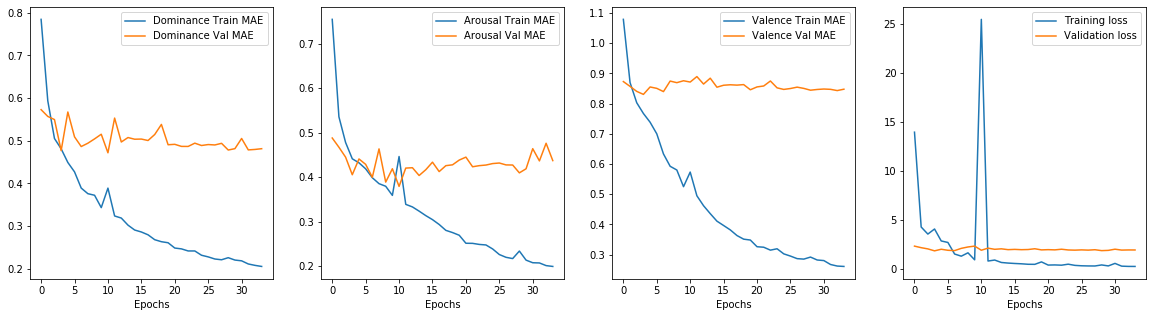

In [48]:
history = model.fit(gen_train, epochs=1000, steps_per_epoch=trainidx/batch_size, validation_data=gen_valid, validation_steps=valididx/batch_size, callbacks=callbacks, batch_size=32)

def plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['dominance_output_mae'], label='Dominance Train MAE')
    axes[0].plot(history.history['val_dominance_output_mae'], label='Dominance Val MAE')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['arousal_output_mae'], label='Arousal Train MAE')
    axes[1].plot(history.history['val_arousal_output_mae'], label='Arousal Val MAE')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['valence_output_mae'], label='Valence Train MAE')
    axes[2].plot(history.history['val_valence_output_mae'], label='Valence Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

## Fine-tuning

In [13]:
from tensorflow.keras.models import load_model

In [14]:
model = load_model("./trained_models/ResNet-2-layer-finetuned")

In [15]:
len(model.layers)

183

In [16]:
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[fine_tune_at:]:
  layer.trainable = True

for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

In [17]:
model.summary()

           
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_0_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_0_bn[0][0]          
                                                                 conv4_block1_3_bn[0][0]          
_________________________________________________________________________________________________

In [18]:
opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, run_eagerly=True,
              loss={'valence_output': 'mse', 'arousal_output': 'mse', 'dominance_output': 'mse'},
              metrics={'valence_output': 'mae', 'arousal_output': 'mae', 'dominance_output': 'mae'})


In [19]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.0001),
    ModelCheckpoint('./trained_models/ResNet-2-layer-finetuned', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]

batch_size = 32
trainidx = len(train_file_list)
testidx = len(test_file_list)
valididx = len(valid_file_list)

In [20]:
history = model.fit(gen_train, epochs=20, steps_per_epoch=trainidx/batch_size, validation_data=gen_valid, validation_steps=valididx/batch_size, callbacks=callbacks, batch_size=32)

def plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['dominance_output_mae'], label='Dominance Train MAE')
    axes[0].plot(history.history['val_dominance_output_mae'], label='Dominance Val MAE')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['arousal_output_mae'], label='Arousal Train MAE')
    axes[1].plot(history.history['val_arousal_output_mae'], label='Arousal Val MAE')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['valence_output_mae'], label='Valence Train MAE')
    axes[2].plot(history.history['val_valence_output_mae'], label='Valence Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

Epoch 1/20
1818/1817 [==============================] - ETA: 0s - loss: 0.0899 - valence_output_loss: 0.0316 - arousal_output_loss: 0.0118 - dominance_output_loss: 0.0465 - valence_output_mae: 0.1356 - arousal_output_mae: 0.0834 - dominance_output_mae: 0.1537
Epoch 00001: val_loss improved from inf to 1.68948, saving model to ./trained_models/ResNet-2-layer-finetuned
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./trained_models/ResNet-2-layer-finetuned/assets
1818/1817 [==============================] - 542s 298ms/step - loss: 0.0899 - valence_output_loss: 0.0316 - arousal_output_loss: 0.0118 - dominance_output_loss: 0.0465 - valence_output_mae: 0.1356 - arousal_output_mae: 0.0834 - dominance_output_mae: 0.1537 - val_loss: 1.6895 - val_valence_output_loss: 1.0332 - 

KeyboardInterrupt: 

Best validation loss: 1.67562

## Validation

In [15]:
from tensorflow.keras.models import load_model

model = load_model("./trained_models/ResNet-2-layer-finetuned")

In [16]:
batch_size = 32
trainidx = len(train_file_list)
testidx = len(test_file_list)
valididx = len(valid_file_list)

In [19]:
model.evaluate(gen_valid, steps=valididx/batch_size)

390/389 [==============================] - 59s 152ms/step - loss: 1.6944 - valence_output_loss: 1.0343 - arousal_output_loss: 0.3011 - dominance_output_loss: 0.3590 - valence_output_mean_absolute_error: 0.7949 - arousal_output_mean_absolute_error: 0.3967 - dominance_output_mean_absolute_error: 0.4468


[1.6943634748458862,
 1.0342873334884644,
 0.3011007010936737,
 0.3589756190776825,
 0.7949418425559998,
 0.3966708183288574,
 0.44681936502456665]

In [21]:
del model

In [26]:
model = load_model("./trained_models/Resnet_finetuned")

In [27]:
model.evaluate(gen_valid, steps=valididx/batch_size)

390/389 [==============================] - 59s 152ms/step - loss: 1.6630 - valence_output_loss: 1.0254 - arousal_output_loss: 0.2782 - dominance_output_loss: 0.3595 - valence_output_mean_absolute_error: 0.7908 - arousal_output_mean_absolute_error: 0.3775 - dominance_output_mean_absolute_error: 0.4503


[1.6629842519760132,
 1.0253686904907227,
 0.27815937995910645,
 0.3594566881656647,
 0.790780782699585,
 0.37747588753700256,
 0.45033392310142517]

## Testing

In [20]:
model.evaluate(gen_test, steps=testidx/batch_size)

390/389 [==============================] - 59s 151ms/step - loss: 1.6820 - valence_output_loss: 1.0337 - arousal_output_loss: 0.2946 - dominance_output_loss: 0.3537 - valence_output_mean_absolute_error: 0.7922 - arousal_output_mean_absolute_error: 0.3914 - dominance_output_mean_absolute_error: 0.4404


[1.6819907426834106,
 1.0336750745773315,
 0.29461580514907837,
 0.35370007157325745,
 0.7922421097755432,
 0.39135631918907166,
 0.4404280483722687]

In [28]:
model.evaluate(gen_test, steps=testidx/batch_size)

390/389 [==============================] - 59s 150ms/step - loss: 1.6895 - valence_output_loss: 1.0371 - arousal_output_loss: 0.2851 - dominance_output_loss: 0.3673 - valence_output_mean_absolute_error: 0.7905 - arousal_output_mean_absolute_error: 0.3801 - dominance_output_mean_absolute_error: 0.4484


[1.689467191696167,
 1.0370968580245972,
 0.28509199619293213,
 0.3672787845134735,
 0.7904918789863586,
 0.3800540566444397,
 0.4483596086502075]

In [31]:
from tensorflow.keras.models import load_model
model04 = load_model('./trained_models/Resnet-04-dropout-finetuned')

In [32]:
model04.evaluate(gen_valid, steps=valididx/batch_size)

390/389 [==============================] - 59s 152ms/step - loss: 1.6727 - valence_output_loss: 1.0291 - arousal_output_loss: 0.2748 - dominance_output_loss: 0.3688 - valence_output_mean_absolute_error: 0.7972 - arousal_output_mean_absolute_error: 0.3771 - dominance_output_mean_absolute_error: 0.4565


[1.6727261543273926,
 1.0291322469711304,
 0.27475035190582275,
 0.3688439130783081,
 0.7971697449684143,
 0.37705132365226746,
 0.45652249455451965]

In [33]:
model04.evaluate(gen_test, steps=testidx/batch_size)

390/389 [==============================] - 58s 149ms/step - loss: 1.6490 - valence_output_loss: 1.0099 - arousal_output_loss: 0.2753 - dominance_output_loss: 0.3638 - valence_output_mean_absolute_error: 0.7805 - arousal_output_mean_absolute_error: 0.3774 - dominance_output_mean_absolute_error: 0.4471


[1.6489996910095215,
 1.0099210739135742,
 0.27529409527778625,
 0.36378487944602966,
 0.7804550528526306,
 0.37743890285491943,
 0.4471072554588318]